# Vignette for Non-Parametric Imputation of Epoch-level Accelerometer Data
## Supplementary Materials 
#### Author: Mia S. Tackney 
#### Date: 17 May 2022

## Introduction 

This vignette introduces a suite of R functions which handle epoch-level data from the [GT3X+ accelerometer](https://actigraphcorp.com/support/activity-monitors/gt3xplus/). 

These accelerometers have been used in a number of clinical trials to measure participants' physical activity over the course of a week, before and after an intervention. 

Specifically, functions introduced in this vignette use data on Vector Magnitude (VM) and Step count measured at every epoch (usually set at 5 second intervals) for each participant, and perform the following tasks:
    
* Analyze common missing data patterns in epoch-level accelerometer data; 
* Visualize epoch-level accelerometer data across the measurement period (typically one week);
* Perform non-parametric imputation of missing accelerometer data.


<br>

## Setting up and loading data 
We first install relevant R packages and source files which contain the functions. 

In [3]:
options(warn=-1)
source("00_init.R", echo=F)
source("03_profile_plot_functions_week.R")
source("05_nonparametric_impute_incomp.R")
source("05_nonparametric_impute_nonself_day_functions_helper.R")

We load a dataset which contains simulated data based on a small portion of the PACE-UP trial epoch-level dataset. There are 95 patients in this dataset, each providing seven days' worth of data from their accelerometer. Each row of this dataset represents a 5-second epoch where vector magnitude and step count is measured by the accelerometer. This dataset contains the following variables: 

* Patient ID number  
* Date  
* Day of week  
* Day order 
* Time at the start of the epoch   
* Step count for the duration of the epoch  
* Vector magnitude (VM) for the duration of the epoch  
* Gender
* Age
* BMI at baseline 

The values for patient ID number, Gender, Age and BMI at baseline are fabricated, so these data are not identifiable. These data are extracted from GT3X+ accelerometer using the Actilife Software. Typically, a large number of other variables can be extracted such as time spent in different types of activities.  

In [16]:
Example <- readRDS("Exampledat.RDS")
head(Example)

Age,Gender,Date,Day.of.Week,Day_order,Steps.Counts,Weartime_R,Time,Steps,VM,bmib,ID
55,F,2014-01-23,Thursday,1,5950,914.5833,00:01:00,0,0,27.49702,52
55,F,2014-01-23,Thursday,1,5950,914.5833,00:01:05,0,0,27.49702,52
55,F,2014-01-23,Thursday,1,5950,914.5833,00:01:10,0,0,27.49702,52
55,F,2014-01-23,Thursday,1,5950,914.5833,00:01:15,0,0,27.49702,52
55,F,2014-01-23,Thursday,1,5950,914.5833,00:01:20,0,0,27.49702,52
55,F,2014-01-23,Thursday,1,5950,914.5833,00:01:25,0,0,27.49702,52


<br>


## Analysing epoch-level data 
### Classifying Runs 
The calc_runs() classifies epoch-level data into the following possible activity categories: active, sleep, inactive, nonwear and sleep-extra, and identifies the start and end times of each activity. The output provides: 
* start: the epoch number when the activity starts
* end: the epoch number when the activity ends 
* length: the length, in minutes, of the activity 
* type: the type of activity, which can be active, sleep, inactive, nonwear, sleep-extra
* start_date: the date of the start of activity 
* start_time: the time of the start of activity 
* end_date: the date of the end of the activity 
* end_time: the time of the end of the activity 

We demonstrate for patient 52 the activites across their 7 days.

In [12]:
calc_runs(Example %>% filter(ID=="52"))

start,end,length,type,start_date,start_time,end_date,end_time
1,4796,399.66667,sleep,2014-01-23,00:01:00,2014-01-23,06:40:35
4797,15759,913.66667,active,2014-01-23,06:40:40,2014-01-23,21:54:10
15760,21984,518.75000,sleep,2014-01-23,21:54:15,2014-01-24,06:32:55
21985,32047,838.66667,active,2014-01-24,06:33:00,2014-01-24,20:31:30
32048,39603,629.66667,sleep,2014-01-24,20:31:35,2014-01-25,07:01:10
39604,52579,1081.41667,active,2014-01-25,07:01:15,2014-01-26,01:02:30
52580,58257,473.16667,sleep,2014-01-26,01:02:35,2014-01-26,08:55:40
58258,59462,100.50000,active,2014-01-26,08:55:45,2014-01-26,10:36:05
59463,60581,93.25000,nonwear,2014-01-26,10:36:10,2014-01-26,12:09:20
60582,67329,562.41667,active,2014-01-26,12:09:25,2014-01-26,21:31:40


<br>

### Calculating Weartime 

The calc_weartime() function calculates the weartime for a specific day. The VM of the day is needed as input. For example, for Patient 52, on their first day using the accelerometer (a Thursday), their weartime is calculated as: 

In [13]:
P52_Thurs <- Example %>% filter(ID==52 & Day.of.Week=="Thursday")
calc_weartime(P52_Thurs$VM)

[1] 914.5833

We compute weartime for each patient, for each day of wear, and add it as an additional variable in the dataset. 

In [19]:
Weartime <- Example %>% group_by(ID, Date) %>% summarise(Weartime_R=calc_weartime(VM))
head(Weartime)
Example <- left_join(Example, Weartime, by=c("ID", "Date"))

ID,Date,Weartime_R
1,2014-06-07,722.1667
1,2014-06-08,891.8333
1,2014-06-09,756.4167
1,2014-06-10,763.3333
1,2014-06-11,803.5000
1,2014-06-12,775.0833


<br>

## Visualizing Epoch-level Data 

The plot_week() function takes Epoch-level data for a particular patient and plots the Vector Magnitude across each day, and indicates the different activities throughout the day.

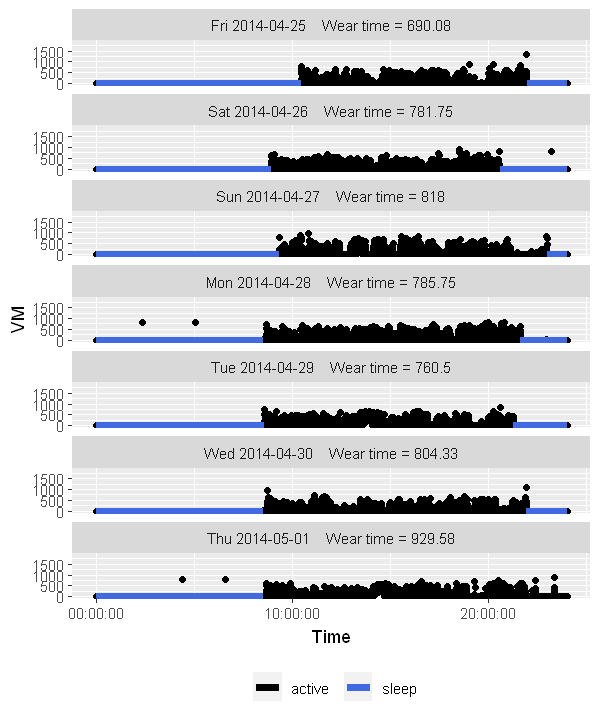

In [17]:
options(repr.plot.width=5, repr.plot.height=6)
Person1 <- Example %>% filter(ID=="34")
Person2 <- Example %>% filter(ID=="52")
p1 <- plot_week(Person1)
p1

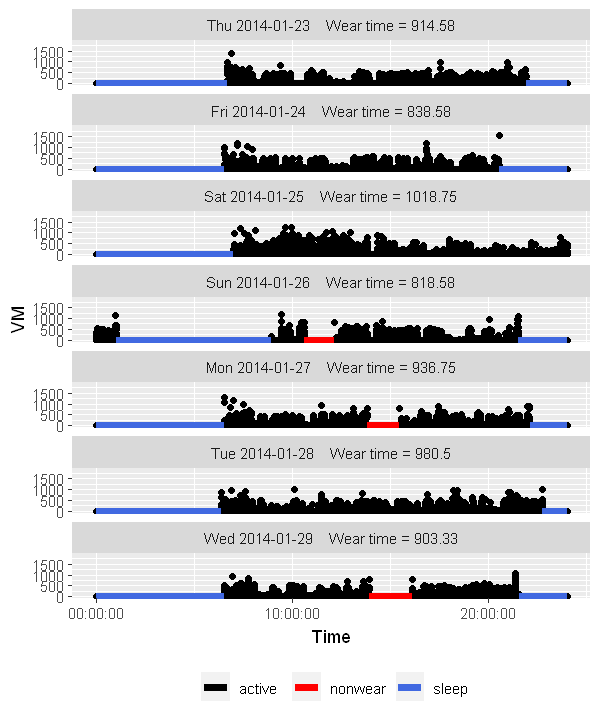

In [18]:
p2 <- plot_week(Person2)
p2

# Non-parametric imputation 

The impute_and_analyse() function carries out non-parametric imputation. In summary, this function carries out the following tasks: 
* Identifies missing periods in the dataset, including nonwear, sleep-extra and whole weeks which need to be imputed. 
* Peforms multiple imputation either using self or non-self donation. By default, if there are less than four donors in the donor pool, non-self donation is carried out. 
* Exports the following files:   
> 1. a file with $M$ copies of the dataset with the total step counts per week for each patient ID. Where there is missingness during the week the $M$ values are different. If there is no missingness, the $M$ values are the same. 
> 2. a file with generic and specific upper bounds for daily step counts for each patient ID, which could be used in STATA to do Tobit regression. 
> 3. a file with missingness patterns saved for each patient ID, which can be used for further analyses. 
* Analyses the data by calculating the mean and standard error of the week-average step counts when non-parametric imputation is used, and when missingness is ignored (available case analysis). 


Inputs for this function is as follows:
* **Simdata**: dataset containing epoch-level data. 
* **sim**: integer for simulation number. Set to 1 by default. 
* **M**: integer greater than 1 for the number of imputations.
* **passive**: function used to transform daily step counts due to skewness. Default is log transformation.
* **path**: path to save upperbounds, which can be used to do parametric imputation in STATA. 
* **imptuations_save_path**: path to save all imputations for all M. This can be used to analyse data using more complex models. 
* **missing_save_path**: path to save missingness classification. 
* **missing_save_path**: path to save results for complete case analysis if complete case analysis is performed.
* **adj_base**: set to NULL if average baseline step count is NOT used as a matching variable (default). set to TRUE if used as a matching variables. 
* **output**: by default set to TRUE if all output is to be shown. Otherwise set to FALSE.

In [21]:
result <- impute_and_analyse(Simdata=Example, sim=1, M=10, passive=log, 
                   path=NULL, imputations_save_path=NULL, missing_save_path=NULL,  cc_save_path=NULL,
                               adj_base=NULL, output=FALSE)
result

sim,Method,mean,se
1,Ignore,6697.374,396.4339
1,Complete Case,NA,NA
1,Non-para,6978.915,372.0837
